In [1]:
import torch
from torchvision import datasets,transforms
import numpy as np
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [65]:
# from 0-255 to 0-1 ,normalizatio nremove skewness and distortion in the data
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),  # Data Augmentation
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [66]:
training_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomAffine(degrees=(0, 0), scale=(0.8, 1.2), shear=(-10, 10))
               ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.8, 1.2], hue=None)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [67]:
#training_loader = torch.utils.data.DataLoader(dataset=training_dataset,batch_size=100,shuffle=True) # shuffle to avoid local minimum

In [68]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

In [69]:
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

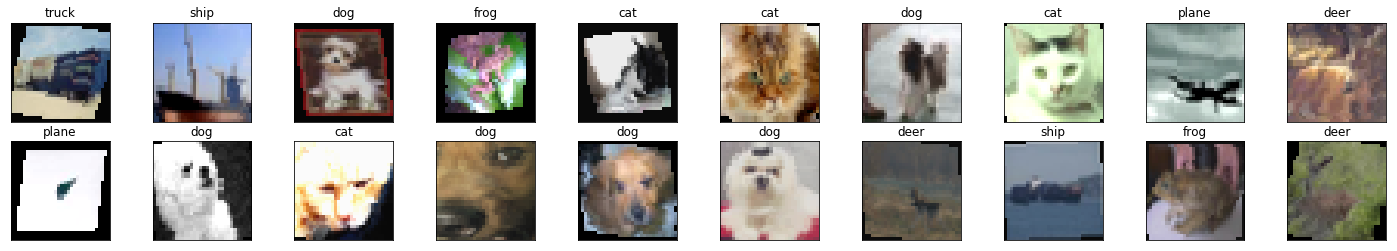

In [70]:
dataiter = iter(training_loader)
images, labels = dataiter.next()   # grab the  batch
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [71]:
class LeNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,1,padding=1)   # 3 channel, 20 conv grid,5 size ,stride 1
        self.conv2 = nn.Conv2d(16,32,3,1,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,1,padding=1)
        self.fc1 = nn.Linear(4*4*64,500)   # size of kernel in last pool, 50 channels
        self.dropout1 = nn.Dropout(0.5)   # dropout between two fc layer
        self.fc2 = nn.Linear(500,10)    # # of fc units and num of classes
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)   # cut the image size by half
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)   # cut the image size by half
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)   # cut the image size by half
        x = x.view(-1,4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [72]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [73]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [74]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for epoch in range(epochs):
    
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    
    for inputs,labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        
        outputs = model(inputs).to(device)
        loss = criterion(outputs,labels).to(device)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _,preds = torch.max(outputs,1)   #maxscores and index
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    
    with torch.no_grad():
        for val_inputs,val_labels in validation_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
        
            
            val_outputs = model(val_inputs).cuda()
            val_loss = criterion(val_outputs,val_labels).cuda()
            
            _,val_preds = torch.max(val_outputs,1)   #maxscores and index
        
            val_running_loss += val_loss.item()
            val_running_corrects += torch.sum(val_preds == val_labels.data).item()
    
    epoch_loss = running_loss / len(training_loader)
    epoch_acc = running_corrects / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_epoch_acc = val_running_corrects / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    
    print('Epoch : ', (epoch + 1))
    print('training loss: {:.4f},accuracy: {:.4f}'.format(epoch_loss,epoch_acc))
    print('validation loss: {:.4f},validation accuracy: {:.4f}'.format(val_epoch_loss,val_epoch_acc))

Epoch :  1
training loss: 1.7004,accuracy: 37.5540
validation loss: 1.3885,validation accuracy: 49.2300
Epoch :  2
training loss: 1.3910,accuracy: 49.7400
validation loss: 1.2130,validation accuracy: 56.2200
Epoch :  3
training loss: 1.2634,accuracy: 54.7520
validation loss: 1.1207,validation accuracy: 60.1700
Epoch :  4
training loss: 1.1741,accuracy: 58.1060
validation loss: 1.1075,validation accuracy: 61.1400
Epoch :  5
training loss: 1.1134,accuracy: 60.5400
validation loss: 1.0156,validation accuracy: 64.4000
Epoch :  6
training loss: 1.0644,accuracy: 62.2380
validation loss: 0.9552,validation accuracy: 66.2300
Epoch :  7
training loss: 1.0250,accuracy: 63.7740
validation loss: 0.9323,validation accuracy: 67.0300
Epoch :  8
training loss: 0.9852,accuracy: 65.2140
validation loss: 0.9110,validation accuracy: 67.6600
Epoch :  9
training loss: 0.9593,accuracy: 66.0400
validation loss: 0.8939,validation accuracy: 68.9300
Epoch :  10
training loss: 0.9276,accuracy: 67.4340
validation l

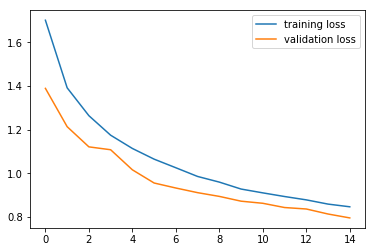

In [75]:
plt.plot(running_loss_history,label='training loss')
plt.plot(val_running_loss_history,label='validation loss')
plt.legend()

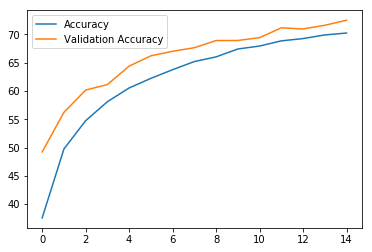

In [76]:
plt.plot(running_corrects_history,label='Accuracy')
plt.plot(val_running_corrects_history,label='Validation Accuracy')
plt.legend()

## Test

In [84]:
len(validation_loader)

100

<Response [200]>


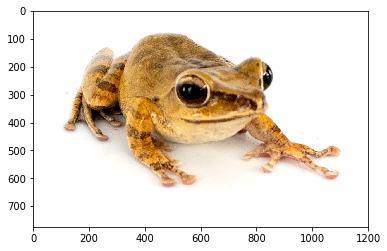

In [85]:
import requests
from PIL import Image
url = 'https://www.joshsfrogs.com/catalog/blog/wp-content/uploads/Golden-Tree-Frog-Frog-Polypedates-leucomystax-31.jpg'
response = requests.get(url,stream= True)
print(response)
img = Image.open(response.raw)
plt.imshow(img)

## Preprocessing the image

In [86]:
import PIL

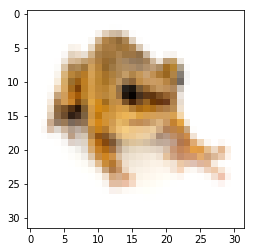

In [87]:

img = transform(img)    # resize the image
plt.imshow(im_convert(img))

In [88]:
img.shape

torch.Size([3, 32, 32])

In [89]:
img = img.to(device)
img = img.unsqueeze(0)
output = model(img).to(device)

            
_,pred = torch.max(output,1)   #maxscores and index
print(classes[pred.item()])

dog


In [90]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

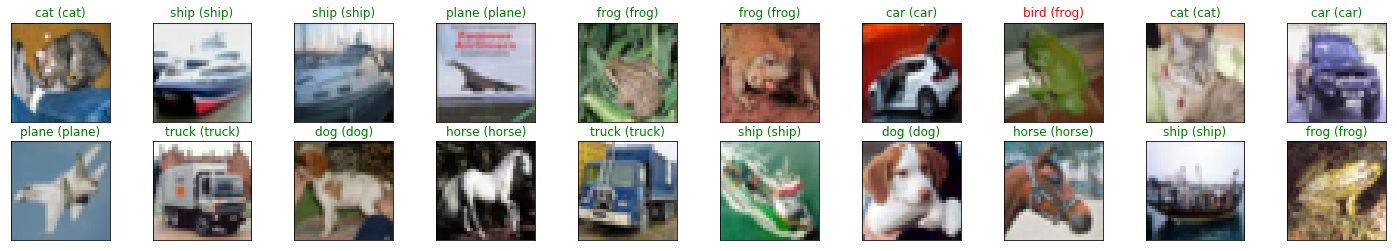

In [91]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()   # grab the  batch
images = images.to(device)
labels = labels.to(device)
output = model(images)
_,preds = torch.max(output,1)   #maxscores and index

fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color = ("green" if preds[idx] == labels[idx] else "red"))